In [112]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn

## The toy experiment
The ATLAS detector and the physics involved are insanely complicated. We will make our life easier by designing a toy project to explore ideas in a controlled environment.

### The problem
A scientist is faced with a strange challenge she has recieved from her eccentric colleague in the robotics-department. He has given her a big square machine which she can not open. It is supplied with electricity and is mounted on a table. 

<p align="center">
  <img src="../fig/toy_experiment_fig1.png" height="250">
</p>

The interface of the machine is very simple:

- There is a screen showing an xy-coordinate system. She can record any position on this screen by any means she wants.
- There are two big buttons which can light up. One is red and one is green. If she pushes one of the buttons, a red dot appears on the screen in what appears to be a new location each time.

<p align="center">
  <img src="../fig/toy_experiment_machine.png" height="250">
</p>

- There is another button with the text ´start simulation´. If she pushes this button one of the two colors light up and then a red dot appears on the screen. This is repeated 100 times. If she pushes it again a new sequence appears.

<p align="center">
  <img src="../fig/toy_experiment_simulate.png" height="350">
</p>

As she is a scientist she believes that she should be able to at least figure _something_ out about this machine by exploring the statistical properties of the observed output.

Her eccentric friend has said that if she can make a fair estimate of the probabilistic mathematical relationship between the color which lights up and the coordinate which is shown she has won the first part of the challenge. He gives her a few hints:

- The relationship between the color and the coordinates is non-deterministic, but there is a logical relationship where color implies coordinate.
- Pressing the simulation-button produces output which are all drawn from the same distribution and is not ordered. Each run is exchangeable and each individual set of color-coordinate pairs is exchangeable.
- Pressing a color button gives us a way to decide the color and sample from the coordinate-distribution of that color.

Mathematically this can be written as:

$P(c_j), c_j \in {red, green}$ 

$0 \lt P(c_j | x, y) \lt P(c_j) < 1$

$P(red) + P(green) = 1$

$P(x_{m}, y_{m} | x_n, y_n) = P(x_{m}, y_{m}), m \neq n$

$P(x, y | c)$



### The robot
Inside the box there is a two-joint robot-arm which draws points on a surface. The screen shows the position of the point the robot arm reached. The position the robot reaches is decided by the parameters $R_1$, $R_2$, $\theta_1$ and $\theta_2$, indicating the length of the first and second rod and the angle of the joints.


$(\theta_1, \theta_2, R_1, R_2) \rightarrow (x, y) = (R_1 \cos(\theta_1) + R_2 \cos(\theta_1 + \theta_2), R_1 \sin(\theta_1) + R_2 \sin(\theta_1 + \theta_2))$

<p align="center">
  <img src="../fig/toy_experiment_robot_arm.png" height="350">
</p>

The robot maker has made the machine non-deterministic by letting three of the four parameters be drawn from fixed distributions according to the color. Internally, the algorithm first decides the color (or a color button is pressed), then $\theta_1, \theta_2$ and $R_1$ are randomly sampled from their distributions:

#### Red

$p(r_1) = 0, 0 \lt r_1 \lt 2R_2 $

$p(r_1) = (r_1)^{(k_{red} -1)} e^{-(r_1)/\alpha} \cdot (\alpha^{k_{red}}\Gamma(k_{red}))^{-1}, 2R_2 \lt r_1  \lt \infty $

$p(\theta_1) = (2\pi)^{-1}, 0 \leq \theta_1 \lt 2\pi$

$p(\theta_2) = (\pi)^{-1}, 0 \leq \theta_1 \lt \pi$


#### Green
$p(r_1) = 0, 0 \lt r_1 \lt 2R_2 $

$p(r_1) = (r_1)^{(k_{green} -1)} e^{-(r_1)/\alpha} \cdot (\alpha^{k_{green}}\Gamma(k_{green}))^{-1}, 2R_2 \lt r_1  \lt \infty $

$p(\theta_1) = (2\pi)^{-1}, 0 \leq \theta_1 \lt 2\pi$

$p(\theta_2) = (\pi)^{-1}, 0 \leq \theta_1 \lt \pi$

When the 'simulation' button is pressed, the colors are drawn from a discrete distribution:

$P("red") = 0.5$

$P("green") = 0.5$




### The experiment

It takes a long time to manually record the results, and she has other things to do so she wants to minimize the time she spends on this experiment. Still, she asks her master students to spend some hours collecting a fair amount of data. To get the probabilities which quantify how fast she is learning, she uses the process of Bayesian inference to update her knowledge. But these calculations take a long time, so she can't use all the data they gathered, and the uncertainties are large... She would like to figure out if machine learning can help her in this project.

In [113]:
def robot_arm(theta1, theta2, r1, r2):
    ya = r1*np.cos(theta1) + r2*np.cos(theta1 + theta2)
    yb = r1*np.sin(theta1) + r2*np.sin(theta1 + theta2)
    return ya, yb

In [134]:
# CONSTANTS
R_2 = 2
rng = np.random.default_rng()
def sample_a1(c, n): return(np.array([random.uniform(0, 2*np.pi) for i in range(n)]))
def sample_a2(c, n): return(np.array([random.uniform(0, 2*np.pi) for i in range(n)]))
def sample_r1(c, n):
    r1_arr = np.zeros(n)
    r1_arr = np.where(c=="red", 2*R_2 + rng.gamma(5, 2, n), r1_arr)
    r1_arr = np.where(c=="green", 2*R_2 + rng.gamma(2, 2, n), r1_arr)
    return r1_arr
def sample_c(n): return(rng.choice(["red", "green"], n))

[ 8.9831167   6.58575711 10.4250587   4.74430979  8.35957825 12.20525401
 13.0193332   8.17310073 13.65267599  8.19673227]


Text(0, 0.5, 'x2')

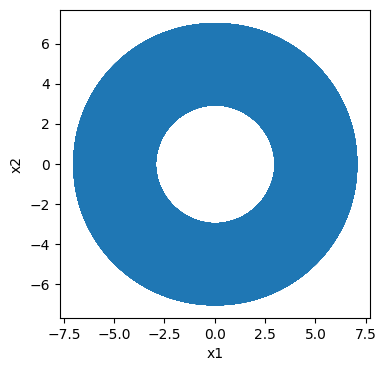

In [135]:
# Look at the mapping function for constant R
nx = 2000
#angles
a1 = np.linspace(-np.pi, np.pi, nx)
a2 = np.linspace(0, np.pi, nx)

aa1, aa2 = np.meshgrid(a1, a2)

xx1, xx2 = robot_arm(aa1, aa2, 5, R_2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4))

ax.scatter(xx1, xx2, s=1, alpha=0.1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")

Text(0, 0.5, 'x1')

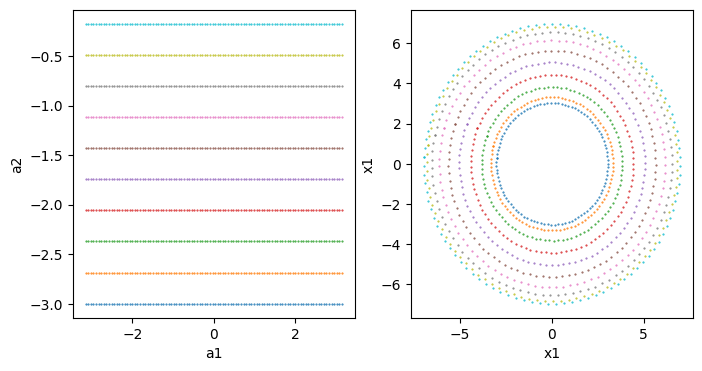

In [136]:
# Look at the mapping function for constant theta2
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a1 = np.linspace(-np.pi, np.pi, na)
for i in range(lines):
    da2 = np.pi/lines
    a2 = 0*a1 -3 + i*da2
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

Text(0, 0.5, 'x1')

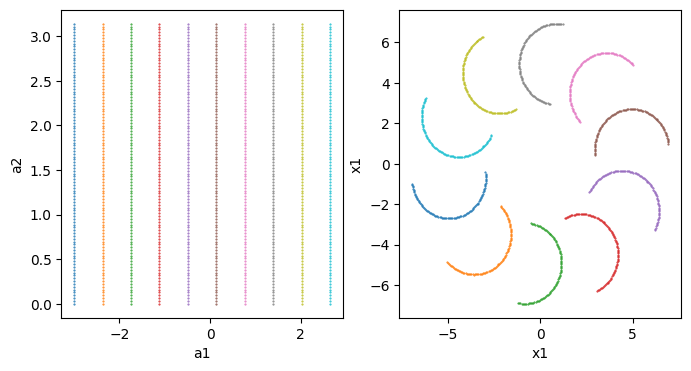

In [137]:
# Look at the mapping function for constant theta1
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a2 = np.linspace(0, np.pi, na)
for i in range(lines):
    da1 = 2*np.pi/lines
    a1 = 0*a2 -3 + i*da1
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

In [151]:

# Generate a very long run datasample

def gen_data(n):
    df_keys = ["color", "x1", "x2", "a1", "a2", "r1", "r2"]
    df = pd.DataFrame(columns=df_keys)
    df["color"] = sample_c(n)
    df["a1"] = sample_a1(df["color"], n)
    df["a2"] = sample_a1(df["color"], n)
    df["r1"] = sample_r1(df["color"], n)
    df["r2"] = R_2
    # Get robot arm value
    x1, x2 = robot_arm(df["a1"], df["a2"], df["r1"], df["r2"])
    df["x1"] = x1
    df["x2"] = x2
    return df
R_1 = [5, 2]
R_2 = 3
df_many = gen_data(10000)

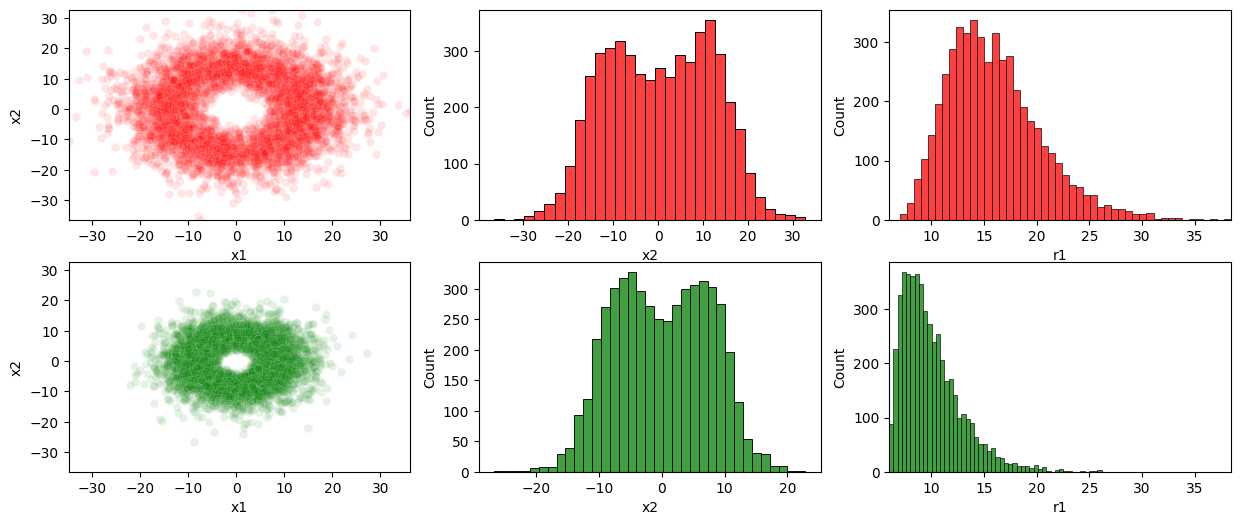

In [152]:
def plot_data(df):

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 6))

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.histplot(df_red, x="x2", color="red", ax=ax[0][1])
    sn.histplot(df_red, x="r1", color="red", ax=ax[0][2])

    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
    sn.histplot(df_green, x="x2", color="green", ax=ax[1][1])
    sn.histplot(df_green, x="r1", color="green", ax=ax[1][2])
    ax[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[0][2].set_xlim(min(df["r1"]), max(df["r1"]))
    ax[1][2].set_xlim(min(df["r1"]), max(df["r1"]))

    return fig, ax

fig, ax = plot_data(df_many)

In [153]:
# Generate training data
df_cal = gen_data(200)
df_train = gen_data(2000)

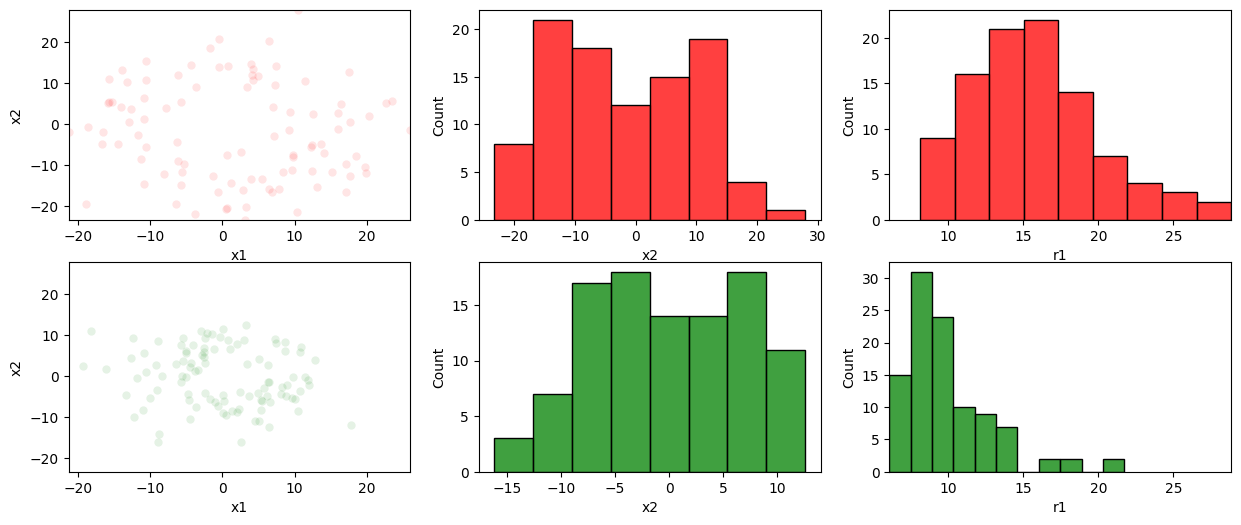

In [154]:
fig, ax = plot_data(df_cal)

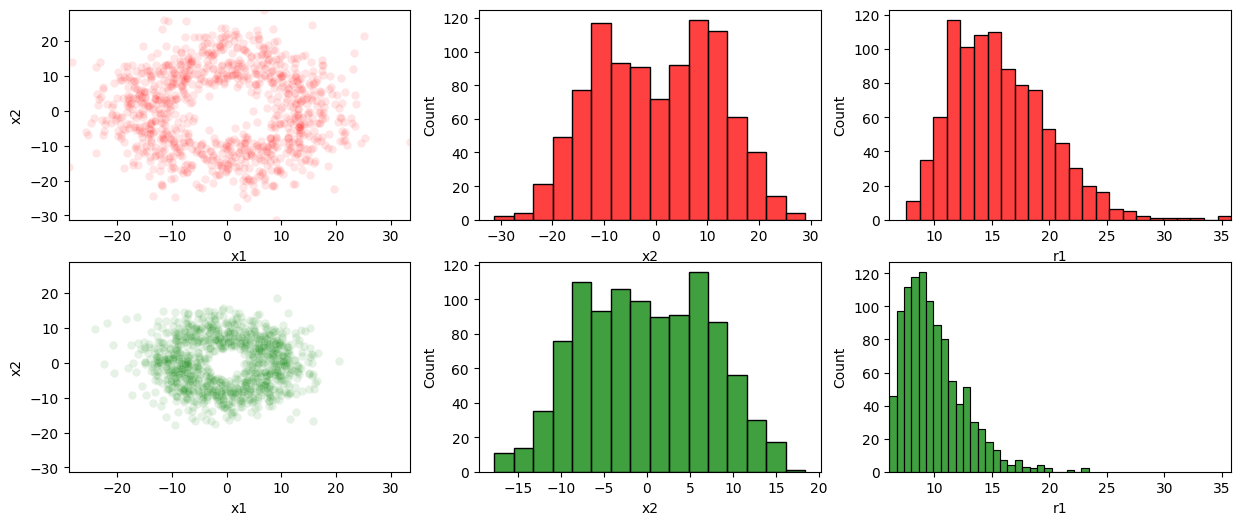

In [155]:
df_test = gen_data(2000)
fig, ax = plot_data(df_test)

In [156]:
df_test

,color,x1,x2,a1,a2,r1,r2
0,green,10.966608,0.953707,0.036111,0.186804,8.046082,3
1,red,-5.959510,10.537630,2.101145,6.219998,9.110594,3
2,red,-7.332069,9.255932,2.002509,1.950415,12.586340,3
3,green,-11.582754,14.875977,2.097496,1.006595,17.078079,3
4,red,-14.871934,3.895595,3.010730,5.587967,12.949366,3
...,...,...,...,...,...,...,...
1995,green,-3.444694,10.668262,1.612917,1.641913,11.017019,3
1996,green,9.229867,-2.102000,5.899760,0.524954,6.749989,3
1997,green,-9.146779,3.706535,3.052788,4.995322,8.601941,3
1998,red,-13.893947,15.538524,2.440192,4.459893,21.390425,3


In [157]:
# Save data
df_train.to_csv("data/train.csv", index=False)
df_cal.to_csv("data/cal.csv", index=False)
df_test.to_csv("data/test.csv", index=False)